### Housekeeping

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import itertools

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from fbprophet import Prophet
from pylab import rcParams

In [2]:
# Styling for sns
sns.set_style("white")

In [3]:
# Import the Sales table
conn = sqlite3.connect('IowaLiquorSales.db')
sales = pd.read_sql_query(
        "SELECT * FROM Sales", conn)
sales['Date'] = pd.to_datetime(sales['Date'], format='%Y/%m/%d')
sales['County'] = sales['County'].str.upper()

# Categorize the liquor stores into types
sales['StoreType'] = 'General Store'
sales.loc[sales.StoreName.str.contains('Food Store'), 'StoreType'] = 'Food Store'
sales.loc[sales.StoreName.str.contains('Wine & Spirits'), 'StoreType'] = 'Wine & Spirits'
sales.loc[sales.StoreName.str.contains('Food & Drug'), 'StoreType'] = 'Food & Drugstore'
sales.loc[sales.StoreName=='Drugstore', 'StoreType'] = 'Drugstore'

sales.head(1)

,ProductID,ProductName,Date,Sale,BottlesSold,StoreID,StoreName,CategoryName,BottleVolume,VendorID,VendorName,County,Age,Proof,Long,Lat,StoreType
0,15628,Jameson,2020-07-01,97.44,2,2643,Hy-Vee Wine and Spirits / Waterloo,Irish Whiskies,1750,370.0,PERNOD RICARD USA,BLACK HAWK,0.0,80.0,NaN,NaN,General Store


In [4]:
# Store location df
stloc = sales[['StoreID','Lat','Long']].drop_duplicates()

### Store Segmentation

We will use the data driven RFM analysis for segmenting the Hy-Vee stores into three distinct categories based on their overall scores

- High Value
- Mid Value
- Low Value


Text(0.5, 1.0, 'Days Since Last Purchase')

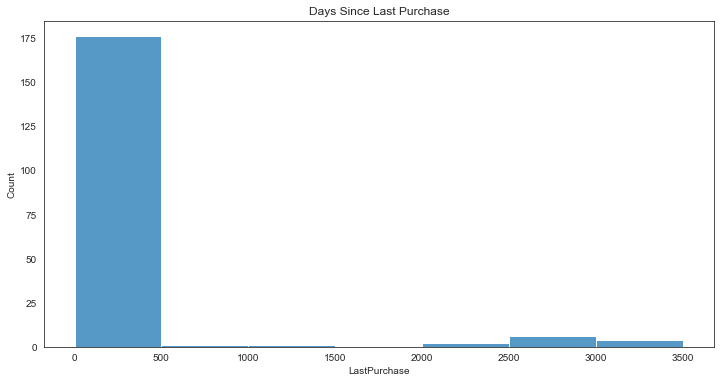

In [7]:
# Recency - Stores with the most recent purchases
df = sales.groupby('StoreID').Date.max().reset_index()
df.columns = ['StoreID', 'maxDate']
df['LastPurchase'] = (df['maxDate'].max() - df['maxDate']).dt.days
store = pd.merge(stloc, df, on='StoreID')

f, ax = plt.subplots(figsize = (12,6))
ax = sns.histplot(data=store, x="LastPurchase", binwidth=500, palette="Blues_d")
ax.set_title('Days Since Last Purchase')

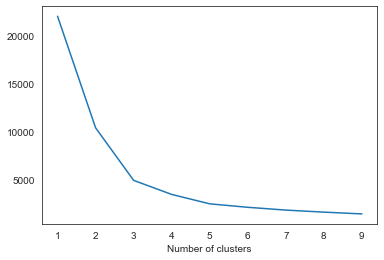

In [8]:
# Identify the number of clusters for grouping stores
stdemand = sales.groupby(['StoreID', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum')).reset_index()
stdemand = stdemand.pivot_table(index=['StoreID'], columns='Date')
stdemand.fillna(0, inplace=True)
features = store['LastPurchase'].to_numpy().reshape(-1,1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(stdemand)

# Using elbow method to identify no. of clusters
rng = np.random.RandomState(42)
sse={}
kmeans_features = scaled_features
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, 
                    max_iter=1000,
                    random_state=rng).fit(kmeans_features)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [9]:
# Initialize the model
kmeans = KMeans(
    init='random',
    n_clusters=4,
    n_init=10,
    max_iter=1000,
    random_state=rng
)

In [10]:
# Set the clusters
kmeans.fit(scaled_features)
cols = list(store.columns.values) + ['rcluster']
rcluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
rcluster.columns = cols

rranking = rcluster.groupby('rcluster').LastPurchase.describe().sort_values(by='mean', ascending=True)
rranking = rranking.reset_index().reset_index()
rranking = rranking.loc[:,['index','rcluster','mean']]
rranking.columns = ['rrank','rcluster','rmean']
rcluster = pd.merge(rcluster, rranking, on='rcluster')

Text(0.5, 1.0, 'Ranking based on Recency')

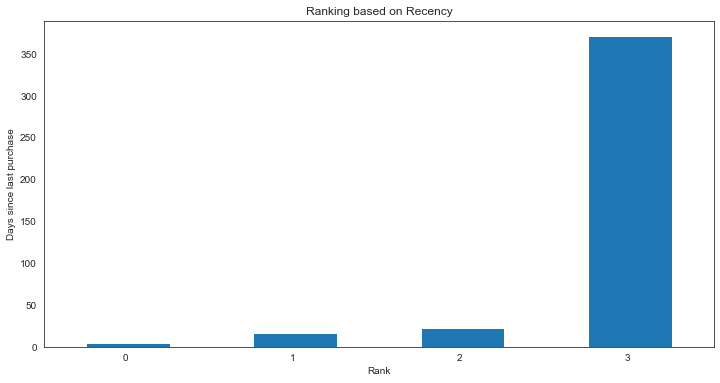

In [11]:
f, ax = plt.subplots(figsize = (12,6))
temp = rcluster.groupby('rrank').agg(mean=('rmean','mean')).plot(kind='bar', ylabel='Days since last purchase', xlabel ='Rank', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right')
ax.get_legend().remove()
ax.set_title('Ranking based on Recency')

Text(0.5, 1.0, 'Frequency of Transactions')

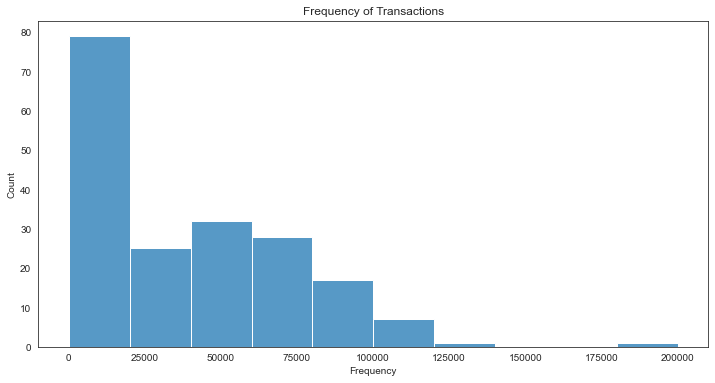

In [12]:
# Frequency - Stores with most number of transactions
df = sales.groupby('StoreID').Sale.count().reset_index()
df.columns = ['StoreID', 'Frequency']
store = pd.merge(stloc, df, on ='StoreID')

f, ax = plt.subplots(figsize = (12,6))
ax = sns.histplot(data=store, x="Frequency", binwidth=20000, palette="Blues_d")
ax.set_title('Frequency of Transactions')

In [13]:
# Set the clusters
features = store['Frequency'].to_numpy().reshape(-1,1)
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

cols = list(store.columns.values) + ['fcluster']
fcluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
fcluster.columns = cols

franking = fcluster.groupby('fcluster').Frequency.describe().sort_values(by='mean')
franking = franking.reset_index().reset_index()
franking = franking.loc[:,['index','fcluster','mean']]
franking.columns = ['frank','fcluster','fmean']
fcluster = pd.merge(fcluster, franking, on='fcluster')

Text(0.5, 1.0, 'Ranking based on Frequency')

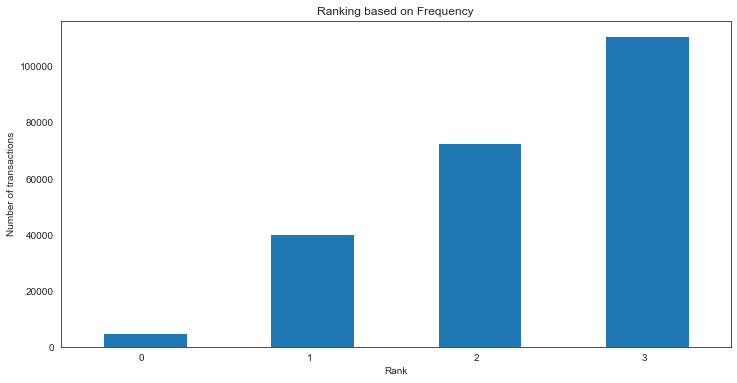

In [14]:
f, ax = plt.subplots(figsize = (12,6))
temp = fcluster.groupby('frank').agg(mean=('fmean','mean')).plot(kind='bar', ylabel='Number of transactions', xlabel='Rank', ax = ax)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right')
ax.set_title('Ranking based on Frequency')

Text(0.5, 0, 'Value (million)')

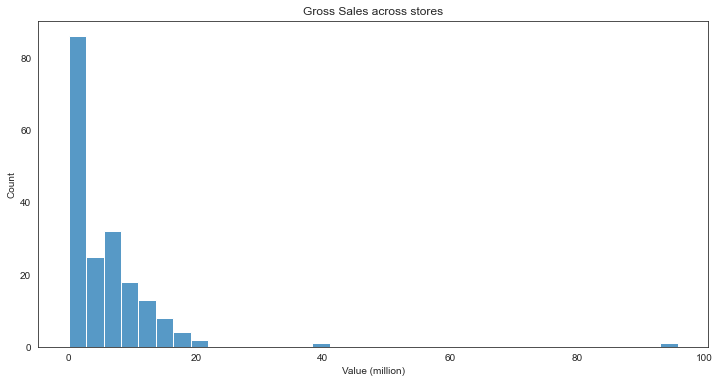

In [15]:
# Monetization - Stores with the highest gross sales
df = sales.groupby('StoreID').Sale.sum().reset_index()
df.columns = ['StoreID', 'Value']
store = pd.merge(stloc, df, on ='StoreID')

f, ax = plt.subplots(figsize = (12,6))
ax = sns.histplot(data=store, x=store['Value']/10**6, palette="Blues_d")
ax.set_title('Gross Sales across stores')
ax.set_xlabel('Value (million)')

In [16]:
# Set the cluster
features = store['Value'].to_numpy().reshape(-1,1)
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

cols = list(store.columns.values) + ['vcluster']
vcluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
vcluster.columns = cols

vranking = vcluster.groupby('vcluster').Value.describe().sort_values(by='mean')
vranking = vranking.reset_index().reset_index()
vranking = vranking.loc[:,['index','vcluster','mean']]
vranking.columns = ['vrank','vcluster','vmean']
vcluster = pd.merge(vcluster,vranking, on = 'vcluster')

Text(0.5, 1.0, 'Ranking based on Monetization')

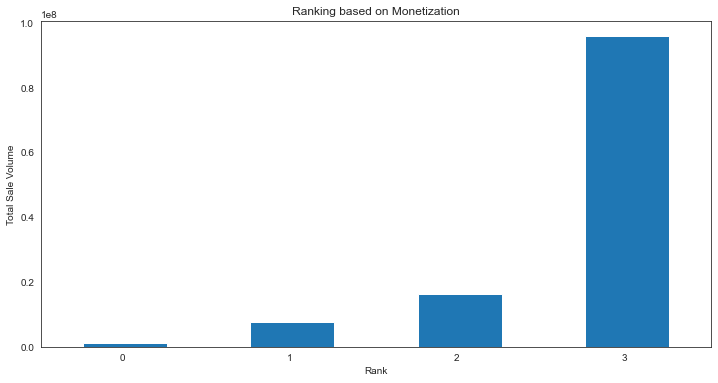

In [17]:
f, ax = plt.subplots(figsize = (12,6))
temp = vcluster.groupby('vrank').agg(mean=('vmean','mean')).plot(kind='bar', ylabel='Total Sale Volume', xlabel='Rank', ax = ax)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right')
ax.set_title('Ranking based on Monetization')

In [18]:
# Overall RFM scores 
score = pd.merge(store, rcluster[['StoreID','rrank']], on='StoreID')
score = pd.merge(score, fcluster[['StoreID','frank']], on='StoreID')
score = pd.merge(score, vcluster[['StoreID','vrank']], on='StoreID')

score['OverallScore'] =  score['rrank'] + score['frank'] + score['vrank']
score['CustomerSegment'] = 'Low-Value'
score.loc[score['OverallScore']>2, 'CustomerSegment'] = 'Mid-Value'
score.loc[score['OverallScore']>4, 'CustomerSegment'] = 'High-Value'

Text(0.5, 1.0, 'Store segmentation based on overall RFM scores')

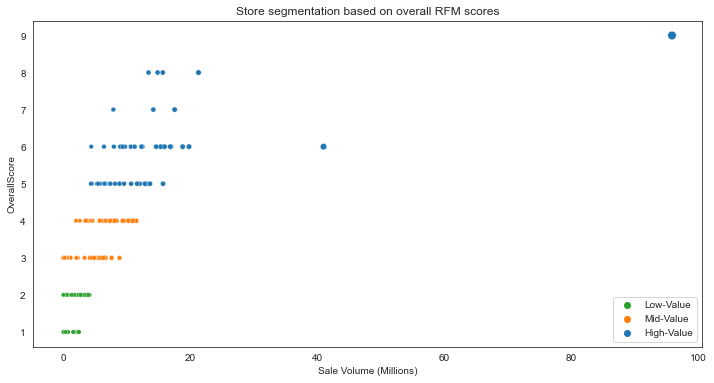

In [50]:
f, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(
    data=score,
    y='OverallScore',
    x=score['Value']/10**6,
    hue='CustomerSegment',
    size=score['Value'],
    palette='tab10',
    ax=ax
)

h,l = ax.get_legend_handles_labels()
h = [h[3], h[2], h[1]]
l = [l[3], l[2], l[1]]

ax.legend(h,l,loc=4)
ax.set_xlabel('Overall Score')
ax.set_xlabel('Sale Volume (Millions)')
ax.set_title('Store segmentation based on overall RFM scores')

In [52]:
# The most valuable stores
score[((score['Value']/10**6)>40) & (score.OverallScore>=7)].sort_values(by='Value', ascending=False)

,StoreID,Lat,Long,Value,rrank,frank,vrank,OverallScore,CustomerSegment
85,2633,41.55,-93.6,9.583955e+07,3,3,3,9,High-Value


In [55]:
# The stores with high growth potential
score[(score.OverallScore>=7) & ((score['Value']/10**6)<40)].sort_values(by='Value', ascending=False)

,StoreID,Lat,Long,Value,rrank,frank,vrank,OverallScore,CustomerSegment
10,2625,NaN,NaN,2.129486e+07,3,3,2,8,High-Value
51,2670,41.68,-91.59,1.753222e+07,3,2,2,7,High-Value
43,2629,41.24,-95.83,1.566599e+07,3,3,2,8,High-Value
72,2603,41.55,-90.48,1.484906e+07,3,3,2,8,High-Value
56,2561,41.54,-93.64,1.418649e+07,3,2,2,7,High-Value
6,2647,42.03,-91.70,1.342957e+07,3,3,2,8,High-Value
9,2565,43.15,-95.15,7.887360e+06,3,3,1,7,High-Value


### Market Basket Analysis

We will identify the top items with highest sales volume in the most valuable store (identified from above) and then perform market basket analysis for these items

In [61]:
# Connect to db and load table
conn = sqlite3.connect('IowaLiquorSales.db')
product = pd.read_sql_query(
    "SELECT ProductID, ProductName from Product", conn
)
product = product.astype(str)
product.shape

(10303, 2)

In [62]:
product.head(1)

,ProductID,ProductName
0,15628,jameson


In [65]:
# Fetch the top 150 highest selling items
productsales = sales.groupby('ProductID').sum().sort_values(by='Sale', ascending=False)
productsales = productsales.reset_index()[['ProductID', 'Sale']]
productsales = productsales.sort_values(by='Sale', ascending=False)
productsales = productsales.loc[0:150,]
productsales.drop(columns='Sale', inplace=True)
productsales = productsales.astype(str)
productsales = productsales.merge(product, on='ProductID')
productsales.head(1)

,ProductID,ProductName
0,11788,black velvet


In [ ]:
# Sale of the top items in the most valuable store
valuestore = sales.loc[sales['StoreID'] == '2633']
valuestore.ProductID = valuestore.ProductID.astype(str)
valuestore = valuestore.merge(productsales.reset_index()['ProductID'], on='ProductID')
valuestore = valuestore.groupby(['ProductID', 'ProductName',pd.Grouper(key = 'Date', freq='W')]).agg(Sale=('Sale','sum'))
valuestore = valuestore.pivot_table(values='Sale', index=['Date'], columns=['ProductID','ProductName'], aggfunc=np.sum)
valuestore.fillna(0, inplace=True)


In [77]:
# Assign 1 to every item sold in a transaction
for col in valuestore.columns:
    valuestore.loc[valuestore[col]>0, col] = 1
valuestore = valuestore.astype(int)

In [78]:
# Using association rule mining for identifying underlying relation between the products in terms of sale
frequentpurchases = apriori(valuestore, min_support=0.5, use_colnames=True, max_len=2)
rules = association_rules(frequentpurchases, metric="lift")
rules[(rules['lift']>.6) & (rules['confidence']>0.8)]
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents', 'consequents','confidence']].head(15)

,antecedents,consequents,confidence
731,"((43338, Captain Morgan Spiced Rum))","((36307, Hawkeye Vodka))",1.0
902,"((43127, Bacardi Superior Rum))","((69637, Dr. Mcgillicuddy's Cherry Schnapps))",1.0
746,"((67527, Kahlua Coffee Liqueur))","((36307, Hawkeye Vodka))",1.0
422,"((19477, Maker's Mark))","((36307, Hawkeye Vodka))",1.0
183,"((43127, Bacardi Superior Rum))","((11777, Black Velvet))",1.0
720,"((41694, Uv Blue (raspberry) Vodka))","((36307, Hawkeye Vodka))",1.0
758,"((88296, Patron Tequila Silver))","((36307, Hawkeye Vodka))",1.0
763,"((89198, Jose Cuervo Especial Reposado Tequila))","((36307, Hawkeye Vodka))",1.0
765,"((89387, Juarez Tequila Gold))","((36307, Hawkeye Vodka))",1.0
128,"((11298, Crown Royal Canadian Whisky))","((36307, Hawkeye Vodka))",1.0


### Time Series analysis and demand forecasting

- Trend Extraction
- ARIMA modelling
- Validation
- Forecasting
- Market Trend

In [22]:
# Load the sales data for store 2633
store = sales.loc[sales['StoreID'] == '2633']
store = store.groupby('Date')['Sale'].sum().reset_index()
store = store.set_index('Date')

Text(0.5, 1.0, 'Sales for store Hy-Vee Des Moines')

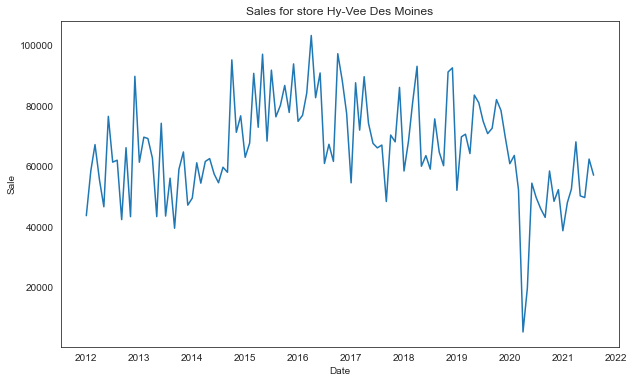

In [23]:
# Trend extraction
df = store['Sale'].resample('MS').mean()
f, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(data=df, palette="Blues_d")
ax.set_title('Sales for store Hy-Vee Des Moines')

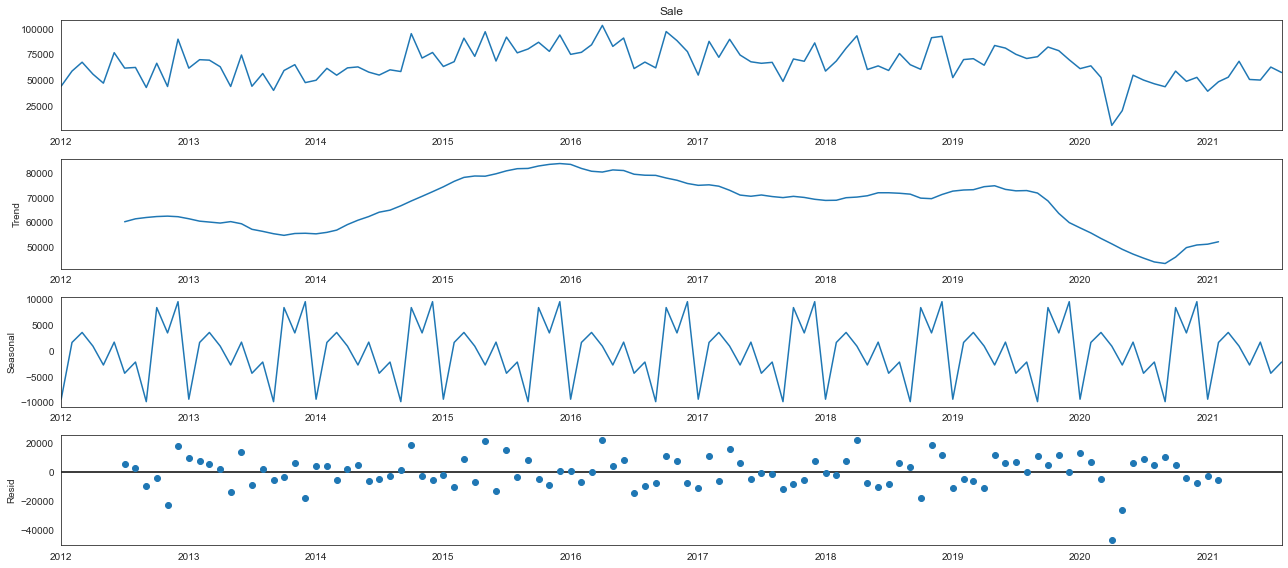

In [24]:
rcParams['figure.figsize'] = 18,8
decomposition =  sm.tsa.seasonal_decompose(df, model = 'additive')
fig = decomposition.plot()

In [25]:
# ARIMA modelling

In [26]:
# Tuning the hyper-parameters for the model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2888.2751133100296
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2530.428180818881
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2337.9183620767576
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2061.9091154763596
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2358.14044147165
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2330.9560486690025
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2081.318388108076
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2061.325614295381
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2798.5635079489584
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2485.595351871743
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2306.33170401338
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2026.9797216750956
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2519.8745846293364
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2472.7814187182544
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2070.1022884158197
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2027.4341737331517
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2550.3814541582356
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2273.9576004708165


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6527      0.098     -6.686      0.000      -0.844      -0.461
ma.S.L12      -0.7123      0.102     -6.991      0.000      -0.912      -0.513
sigma2      3.623e+08   8.02e-11   4.52e+18      0.000    3.62e+08    3.62e+08


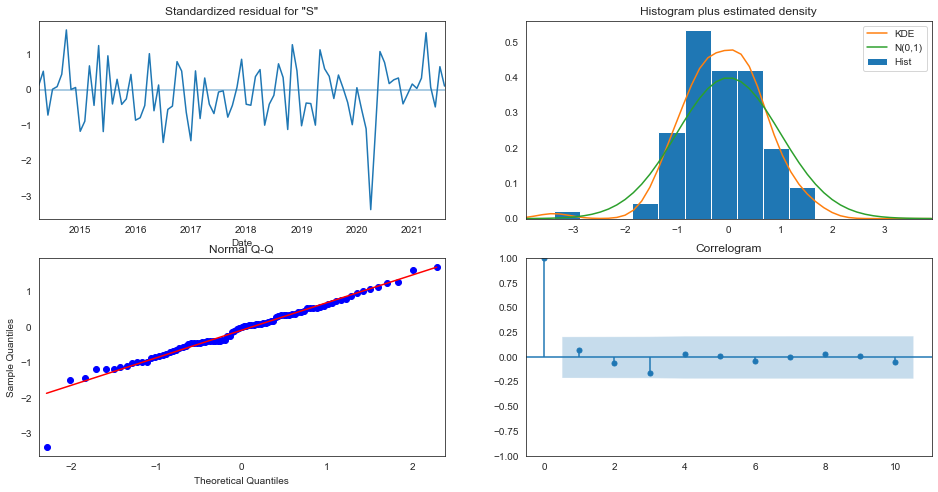

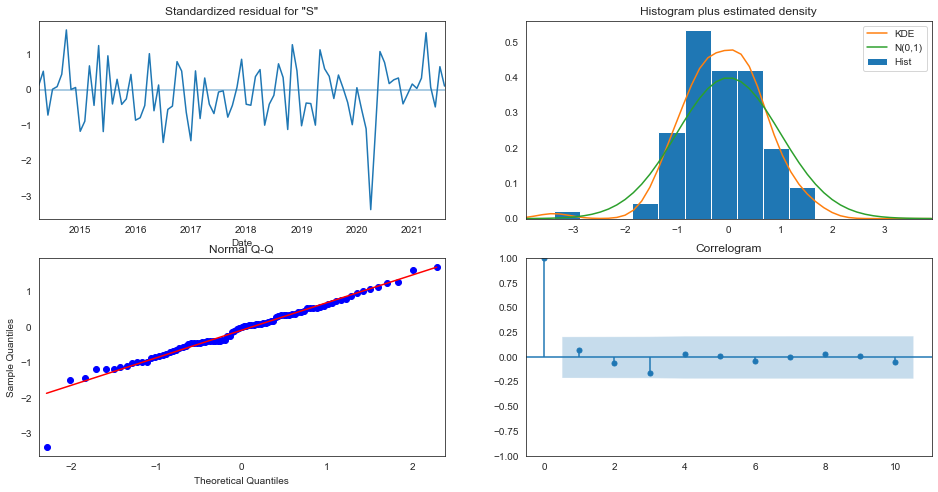

In [27]:
# Fitting the model
mod = sm.tsa.statespace.SARIMAX(df,
                                order = (0,1,1),
                                seasonal_order = (0,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize = (16,8))

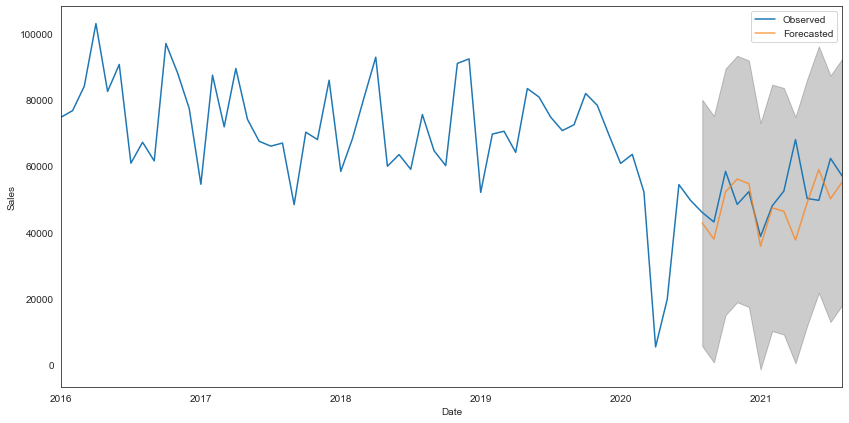

In [28]:
# Validate by generating prediction for the final year (2020-Aug - 2021-Aug) 
# and compare it to the observed values over the same time period. 
pred = results.get_prediction(start=pd.to_datetime('2020-08-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2016':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [29]:
forecasted = pred.predicted_mean
truth = df['2016-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 104229781.95
The Root Mean Squared Error of our forecasts is 10209.3


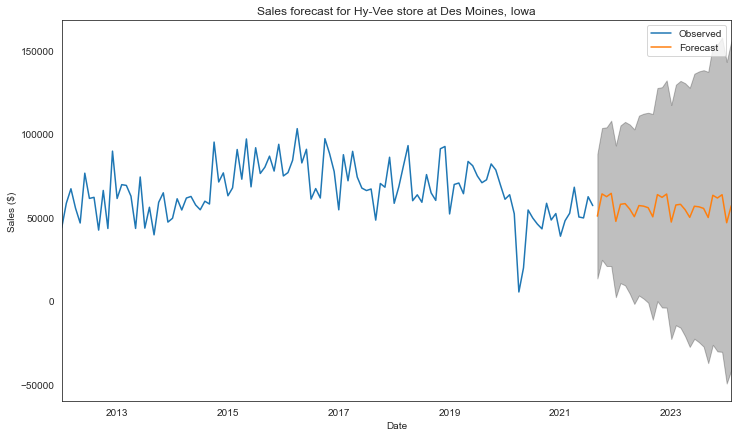

In [30]:
# Forecasting
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='Observed', figsize=(12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales ($)')
ax.set_title('Sales forecast for Hy-Vee store at Des Moines, Iowa')
plt.legend()

In [31]:
# Forecasting with Prophet
store = store.reset_index().rename(columns = {'Date': 'ds', 'Sale': 'y'})
store_model = Prophet(interval_width = 0.95)
store_model.fit(store)

store_forecast = store_model.make_future_dataframe(periods=36, freq = 'MS')
store_forecast = store_model.predict(store_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Sales forecast for Hy-Vee store at Des Moines, Iowa')

<Figure size 1296x432 with 0 Axes>

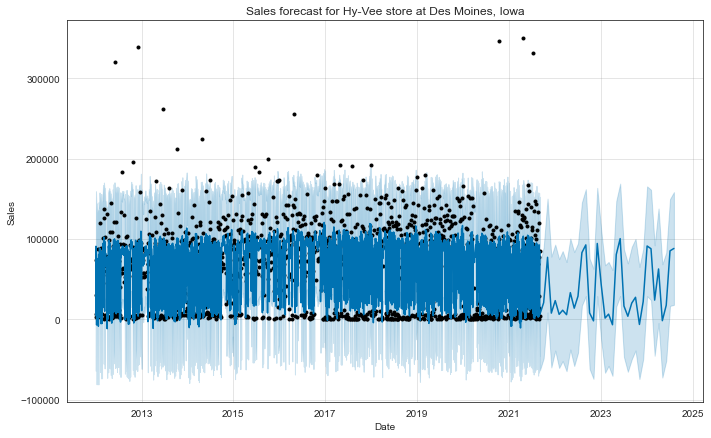

In [32]:
plt.figure(figsize=(18,6))
store_model.plot(store_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Sales forecast for Hy-Vee store at Des Moines, Iowa')

In [33]:
# Market Trend for Hy-Vee
store = sales.copy()
store = store.groupby('Date')['Sale'].sum().reset_index()
store = store.set_index('Date')
y = store['Sale'].resample('MS').mean()

store = pd.DataFrame({'Date': y.index, 'Sale': y.values})
store = store.rename(columns ={'Date': 'ds', 'Sale': 'y'} )
store_model = Prophet(interval_width = 0.95)
store_model.fit(store)

store_forecast = store_model.make_future_dataframe(periods = 36, freq = 'MS')
store_forecast = store_model.predict(store_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Sales forecast for HyVee stores in Iowa')

<Figure size 1296x432 with 0 Axes>

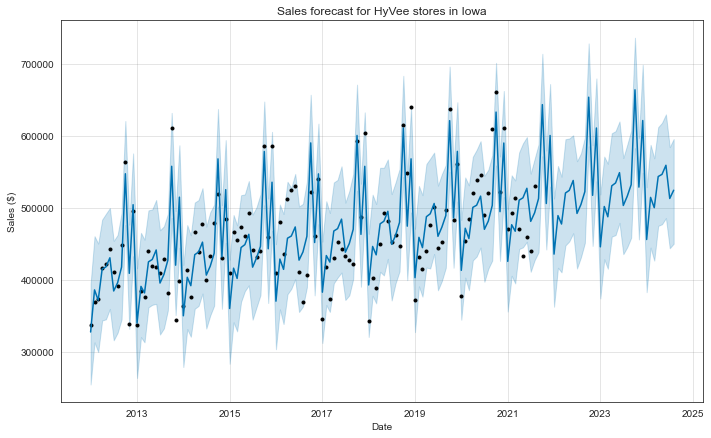

In [34]:
plt.figure(figsize = (18,6))
store_model.plot(store_forecast, xlabel = 'Date', ylabel = 'Sales ($)')
plt.title('Sales forecast for HyVee stores in Iowa')